In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from numpy import random
from multiprocessing import Pool
from itertools import combinations, permutations, product

from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics # silhouette
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from fcmeans import FCM

from scipy.stats import hmean

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_json('data/dev/cluster_12_cats.json')

In [3]:
df.head()

,id,date,title,body,subjects,category
0,3-6475275,2013-01-31T16:59:42+0200,Aika kallis Volkkari,Vuonna 1973 autonvalmistaja Volkswagen oli kr...,"[tekniikka, ulkomaat, liikenne, vw passat, vol...",autot
1,3-6475075,2013-01-31T16:02:43+0200,Kuopion koruryöstäjille kymmenien tuhansien sa...,Poliisi kaipaa edelleen havaintoja keskiviikk...,"[kotimaan uutiset, ryöstö, varallisuusrikokset...",autot
2,3-6474561,2013-01-31T13:24:08+0200,Nuori nainen kuoli kolarissa Virroilla,Etelä-Pohjanmaalla asuva nuori nainen menehty...,"[virrat, räntä, liikenneonnettomuudet, henkilö...",autot
3,3-6474214,2013-01-31T10:54:11+0200,Autoasentajat kurssikierteessä,Kun auton polttimonvaihto vie alan korjaamoll...,"[kotimaan uutiset, tekniikka, tuulilasinpesin,...",autot
4,3-6474222,2013-01-31T10:54:01+0200,12 kertaa kiinni kortitta ajosta,Kokemäellä autoillut mies jäi keskiviikkona k...,"[ajokortitta ajaminen, kokemäki, liikennerikko...",autot


In [4]:
# df.drop_duplicates(subset ="id", inplace=True, ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207881 entries, 0 to 207880
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        207881 non-null  object
 1   date      207881 non-null  object
 2   title     207881 non-null  object
 3   body      207881 non-null  object
 4   subjects  207881 non-null  object
 5   category  207881 non-null  object
dtypes: object(6)
memory usage: 11.1+ MB


In [48]:
df['id'].nunique()

207881

In [3]:
df['body'] = df['title'] + '. ' + df['body']

In [4]:
stops_fi = set(stopwords.words('finnish'))
stops_fi2 = open("data/stopwords_fi_nlf.txt", "r").readlines()
stops_fi2 = [w.split()[1] for w in stops_fi2]
stops_fi.update(stops_fi2)
stops_fi = list(stops_fi)

In [5]:
def preprocessing(df, stopwords):
    # clean text and title and create new column "tokenized"
    tokens = df['title'].apply(simple_preprocess, max_len=30) + df['body'].apply(simple_preprocess, max_len=30)
    # remove stopwords
    tokens = [w for w in tokens if not w in stopwords]
    return tokens

In [6]:
%%time
df['tokens'] = preprocessing(df, stops_fi)

CPU times: user 1min 5s, sys: 926 ms, total: 1min 6s
Wall time: 1min 6s


In [7]:
df.drop(['title', 'body', 'subjects', 'date'], axis=1, inplace=True)

In [8]:
def get_sample_text(df_text, sample_ids):
    df = df_text.reset_index(drop=True)
    df = df.set_index('id')
    df_sample = df.loc[sample_ids]
    return df_sample


def get_clusters(lda, corpus, min_prob=0.1):
    clusters = [list() for i in range(20)]
    
    for i, doc in enumerate(corpus):
        topics = lda.get_document_topics(doc, minimum_probability=min_prob)
        
        # incase not belong to any topic > threshold
        if len(topics) == 0:
            topics = lda.get_document_topics(doc)
            topics = [topics[0]]

        topics = [t[0] for t in topics]
        
        for topic in topics:
            clusters[topic].append(i)
            
    return clusters

def get_topic_term(lda, dictionary):
    topics = []
    
    for i in range(20):
        terms = lda.get_topic_terms(i, topn=20)
        words = []
        for t in terms:
            words.append(dictionary[t[0]])
        topics.append(words)
        
    return topics

def get_cluster_change(clusters, sample):
    changes = []
    
    for i, ids in enumerate(clusters):
        # merge article index
        cluster = sample.iloc[ids]
        counts = cluster['time'].value_counts().sort_index()
        maj_class = cluster['category'].value_counts(normalize=True).index[0]
        # diff = times.diff().fillna(0)
        changes.append((i, maj_class, counts))
        
    return changes
    

def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

In [9]:
dataset = pickle.load(open("data/dev/dataset_1_event.pkl", "rb"))

In [10]:
def load_model(i):
    path = os.path.join('models/lda/lda_models/lda_sample_' + str(i))
    model = LdaModel.load(path)
    dct = Dictionary.load('models/lda/lda_models/lda_sample_'+ str(i) + '.id2word')
    return model, dct

In [8]:
len(dataset)

2000

In [76]:
#sample = dataset[4].sample(frac=0.3)
sample = dataset[128]
lda, dictionary = load_model(128)

In [43]:
sample.head()

,id,category,time,event
0,3-7171047,työllisyys,61,up_down
1,3-6806795,työllisyys,38,up_down
2,3-6679483,työllisyys,44,up_down
3,3-7239955,työllisyys,36,up_down
4,3-8494528,työllisyys,45,up_down


In [44]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98483 entries, 0 to 98482
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        98483 non-null  object
 1   category  98483 non-null  object
 2   time      98483 non-null  int64 
 3   event     98483 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [12]:
def get_target(df):
    target = df[df['event'] != 'noise']['category'].iloc[0]
    return target

In [78]:
target = get_target(sample)
print(target)

taudit


In [46]:
# sample['category'] = sample['category'].astype('category')
# sample.sort_values('category', inplace=True)
# sample.reset_index(inplace=True, drop=True)

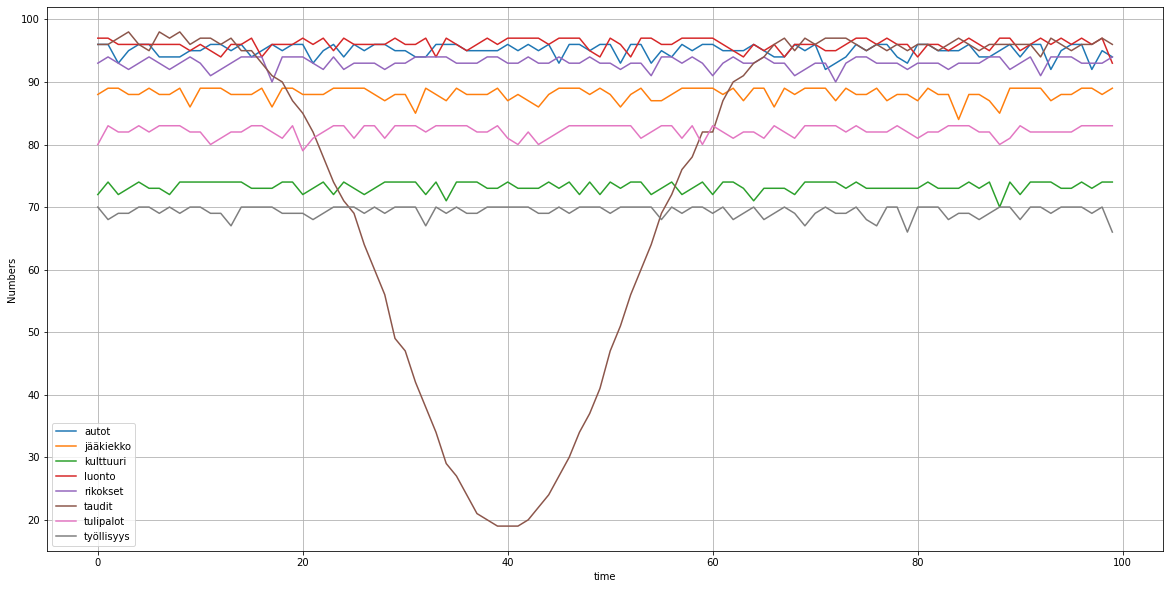

In [77]:
visualize_trending(sample)

In [79]:
sample_text = get_sample_text(df, sample['id'])

In [80]:
corpus = [dictionary.doc2bow(doc) for doc in sample_text['tokens']]

In [81]:
clusters = get_clusters(lda, corpus, min_prob=0.15)

In [82]:
changes = get_cluster_change(clusters, sample)

In [11]:
# %%time
# dictionary = Dictionary.load('models/lda/lda_sample_0.id2word')
# lda = LdaModel.load('models/lda/lda_sample_0')

In [22]:
# changes[0][2]

In [23]:
len(changes)

20

In [11]:
def visualize_changes(changes, target):    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    distance = 0
    target_id = 0
    for cluster, maj_class, counts in changes:
        val = counts.values + distance
        if maj_class == target:
            target_id = cluster
            ax.plot(counts.index, val, label=maj_class, ls='--')
        else:
            ax.plot(counts.index, val, label=maj_class)
            
        distance += 20
    
    ax.set(xlabel='Time', ylabel='Counts')
    ax.legend()
    ax.grid()

    plt.show()
    print('cluster target:', target_id)
    return target_id

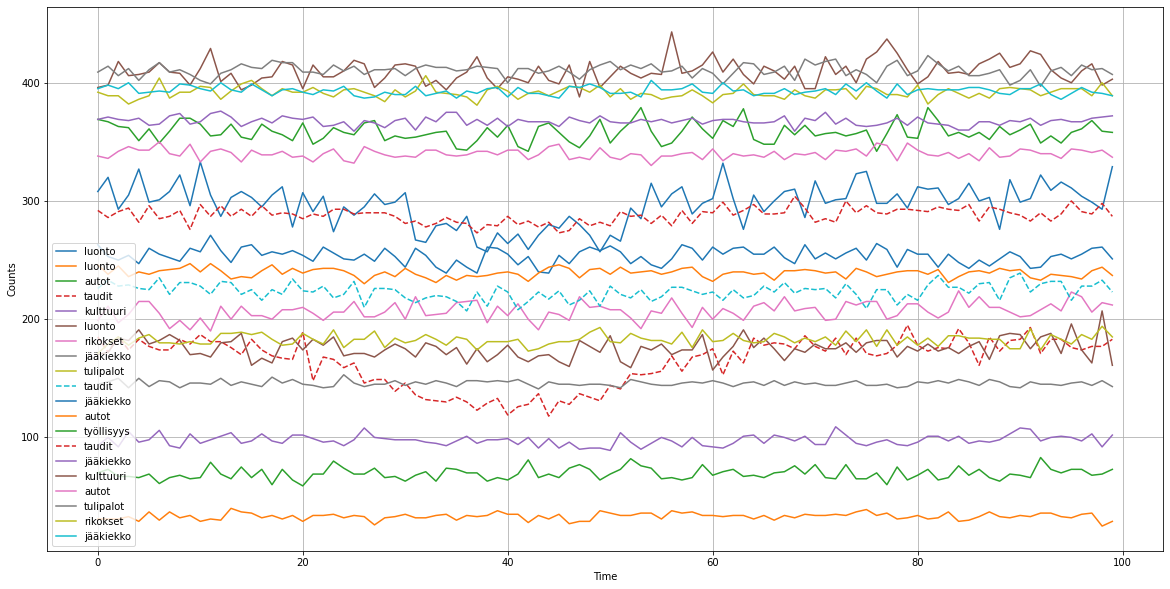

cluster target: 13


In [83]:
target_id = visualize_changes(changes, target)

In [144]:
# sample[sample['cluster'] == target_id]

In [12]:
def cal_change_slope(freqs):
    
    X = np.arange(len(freqs))[:, np.newaxis]
    reg = LinearRegression(normalize=True).fit(X, freqs)
    
    return reg.coef_[0]

def get_slopes_window(freqs, timeline, window=5):
    steps = timeline - window + 1
    X = np.arange(window)[:, np.newaxis]
    
    slopes = np.zeros(steps)
    
    for i in range(steps):
        y = freqs[i:i+window]
        reg = LinearRegression(normalize=True).fit(X, y)
        slopes[i] = reg.coef_[0]
        
    return slopes
    

In [54]:
# slopes = get_slopes_window(changes[target_id][2], 100, window=5)
# cal_change_slope(changes[target_id][2], 100)

In [ ]:
print(slopes)

In [13]:
def get_batch_slopes(changes, timeline, window=5):
    all_slopes = []
    categories = []
    x = np.arange(len(changes))
    
    for cluster, maj_class, freqs in changes:
        slopes = get_slopes_window(freqs, timeline, window)
        all_slopes.append(slopes)
        categories.append(maj_class)
    
    all_slopes = np.abs(np.array(all_slopes))
    #slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    
    return all_slopes, categories
    
    
def get_slopes(changes, timeline, visualize=False):
    slopes = []
    categories = []
    x = np.arange(len(changes))
    
    for cluster, maj_class, freqs in changes:
        slope = cal_change_slope(freqs)
        slopes.append(slope)
        categories.append(maj_class)
    
    slopes = np.abs(np.array(slopes))
    slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    
    if visualize:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.bar(x, height=slopes, tick_label=categories)
        ax.set(xlabel='Clusters', ylabel='Slopes')
    
    return slopes, categories


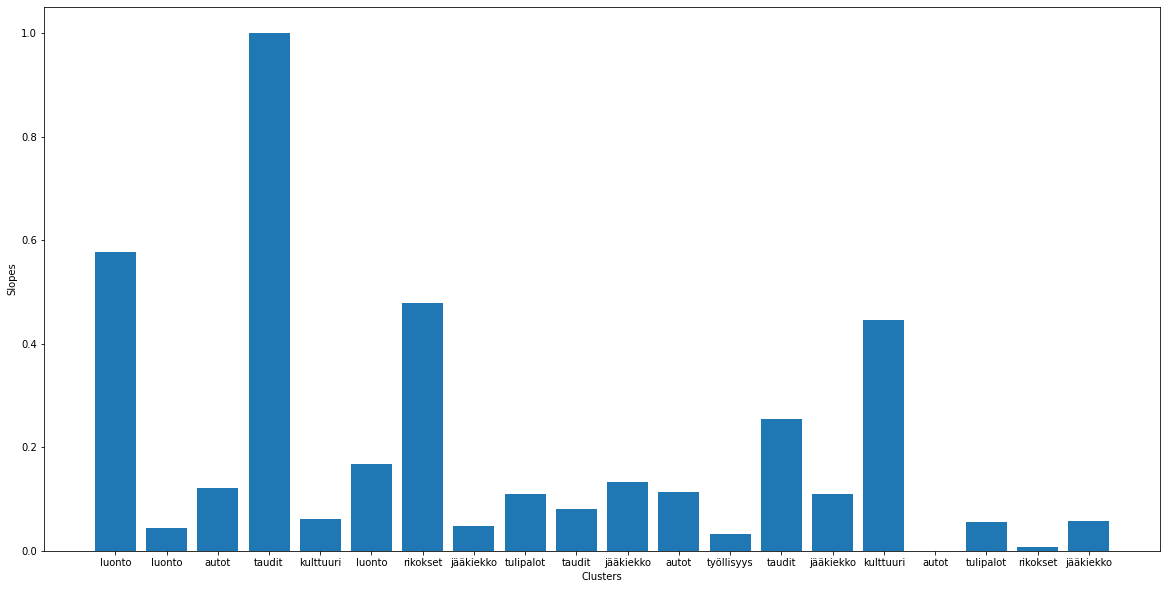

In [84]:
# slopes, cats = get_batch_slopes(changes, 100, window=20)
slopes, cats = get_slopes(changes, 100, visualize=True)

In [14]:
def visualize_slopes_window(slopes, cats, target):
    timeline = range(slopes.shape[1])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    distance = 0
    slopes = slopes
    
    for i, c in enumerate(cats):
        if c == target:
            ax.plot(timeline, slopes[i] + distance, label=c, ls='--')
        else:
            ax.plot(timeline, slopes[i] + distance, label=c)
        
        distance += 2
    
    ax.set(xlabel='Clusters', ylabel='Slopes')
    ax.legend()
    ax.grid()
    fig.show()

In [ ]:
visualize_slopes_window(slopes, cats, target)

In [46]:
# slopes, cats = get_slopes(changes, 100, visualize=True)

In [205]:
print(cats)

['rikokset', 'tulipalot', 'vaalit', 'autot', 'musiikki', 'koulut', 'ruoat', 'luonto', 'jääkiekko', 'taudit', 'kulttuuri', 'taudit']


In [15]:
def get_metrics(df, slopes, maj_cats, clusters, target, threshold=0.5):
    accuracy = 0   # accuracy of detect correctly clusters have the target category as major
    precision = 0  # accuracy of detect how many articles in cluster are target category
    recall = 0    # accuracy of detect how many articles in target category are in choosen clusters
    
    # slopes = np.abs(np.array(slopes))
    pred_ids = np.argwhere(slopes >= threshold).squeeze(1)
    n_cluster = len(pred_ids)
    df['target'] = (df['event'] != 'noise')
    target_cluster = df[df['target'] == True]
    
    for i in pred_ids:
        pred_cat = maj_cats[i]
        cluster = df.iloc[clusters[i]]
        
        if pred_cat == target:
            accuracy += 1
        # calculate the prec and recall

        if len(cluster['target']) > 0:
            precision += cluster['target'].mean()
        recall += cluster['target'].sum()
    
    # if there is output 
    if n_cluster:
        accuracy = accuracy / n_cluster
        precision = precision / n_cluster
        recall = recall / target_cluster.shape[0]
    
    return accuracy, precision, recall
    
    

In [90]:
get_metrics(sample, slopes, cats, clusters, target, threshold=0.7)

(1.0, 0.5400019254837778, 0.7358960902650223)

In [16]:
def evaluate_pipeline(samples, df, threshold=0.5, timeline=100):
    n_samples = len(samples)
    acc = np.zeros(n_samples)
    prc = np.zeros(n_samples)
    rec = np.zeros(n_samples)
    f = np.zeros(n_samples)
    
    for i, sample in enumerate(tqdm(samples)):
        sample.reset_index(inplace=True, drop=True)
        #sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        target = get_target(sample)
        model, dictionary = load_model(i)
        sample_text = get_sample_text(df, sample['id'])
        corpus = [dictionary.doc2bow(doc) for doc in sample_text['tokens']]

        clusters = get_clusters(model, corpus, min_prob=0.15)
        freq_changes = get_cluster_change(clusters, sample)
        
        slopes, cats = get_slopes(freq_changes, timeline)
        
        acc[i], prc[i], rec[i] = get_metrics(sample, slopes, cats, clusters, target, threshold)
        f[i] = 2 * prc[i] * rec[i] / (prc[i] + rec[i])
        
    return acc, prc, rec, f
    

In [105]:
accs, precs, recs, f_micro = evaluate_pipeline(dataset[:138], df,  threshold=0.8, timeline=100)

100%|██████████| 138/138 [1:35:52<00:00, 41.68s/it]


In [106]:
f_macro =2 * precs.mean()*recs.mean()/(precs.mean()+recs.mean())
accs.mean(), precs.mean(), recs.mean()

(0.5078502415458938, 0.3763728733027854, 0.6432840561922948)

In [107]:
f_micro = np.nan_to_num(f_micro)
print("f_micro:", f_micro.mean(), "f_macro:", f_macro)

f_micro: 0.42650282612976004 f_macro: 0.47489437197049456


In [42]:
err_cluster = np.argwhere(accs == 0)

In [17]:
def cache_cluster(samples, df):
    done = list(range(25))
    missing = [139, 141, 1147, 1148, 1150, 1151, 1153, 1155, 1156, 1160, 1164, 1183, 1185, 1186, 1193, 1194, 1197, 1198, 1447, 1449, 1455, 1456, 1457, 1460, 1461]
    missing = done + missing
    
    # data = [i for i in range(2000) if i not in missing]
    data = range(25, 30)
    p = Pool(4)
    
    for i in data:
        p.apply_async(do_cache, args=(i, samples, df))
    
    p.close()
    p.join()
        
def do_cache(i, samples, df):
    print('start', i)
    sample = samples[i]
    sample.reset_index(inplace=True, drop=True)
    model, dictionary = load_model(i)
    sample_text = get_sample_text(df, sample['id'])
    corpus = [dictionary.doc2bow(doc) for doc in sample_text['tokens']]
    clusters = get_clusters(model, corpus, min_prob=0.2)

    # save clusters
    pickle.dump(clusters, open("models/lda_clusters/clusters_"+ str(i) +".pkl", "wb"))
    print('Done:', i)
    return i

#     for i, sample in enumerate(tqdm(samples)):
#         if i in missing:
#             continue
            
#         sample.reset_index(inplace=True, drop=True)

    
        

In [18]:
cache_cluster(dataset, df)

In [ ]:
# 0.3: (0.745, 0.6343292998172704, 0.7697123051348668)
# 0.4: (0.89, 0.7395639037789224, 0.6563455287820337)
# 0.5: (0.8, 0.6640593814713934, 0.512341135418601)


# 0.8: (0.965, 0.7969002902199377, 0.6258688026308521)
# 0.7: (0.935, 0.7743919976040927, 0.6444361047009539)

# More noise: (0.9016666666666666, 0.7086314813655319, 0.6674593527094121)